In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm

In [2]:
rng = np.random.RandomState(12345)

In [3]:
def run_bets(num_rounds, policies, max_p=1.0, rng=rng):
    """
    Run a Monte-Carlo simulation of the quiz, for multiple betting algorithms.
    These are counter-factual simulations - i.e. each algorithm experiences
    the same outcomes of the bets, and differences are purely due to the
    differing amounts they stake.
    """
    
    score_histories = [[100] for _ in policies]
    bet_histories = [[] for _ in policies]
    p_history = []
    
    for n in range(num_rounds):
        p_correct = rng.uniform(low=0.5, high=max_p)
        p_history.append(p_correct)

        outcome = rng.choice(2, p=(1.0 - p_correct, p_correct))
        outcome = outcome*2 - 1
        
        for i, policy in enumerate(policies):
            cash = score_histories[i][-1]
            bet = policy(p_correct, cash)
            # Round to an integer and clip to [0, 10].
            # Should really be done in the policy, but just in case...
            bet = np.clip(int(bet), 0, 10)
            # Prevent betting more than our current wealth.
            if bet > cash:
                bet = cash
            bet_histories[i].append(bet)
            
            score_histories[i].append(cash + outcome*bet)
    
    return score_histories, bet_histories, p_history

In [4]:
def policy_linear(p, s):
    return 10*(2*p - 1)

def policy_const(p, s):
    return 10

Text(0, 0.5, 'Score')

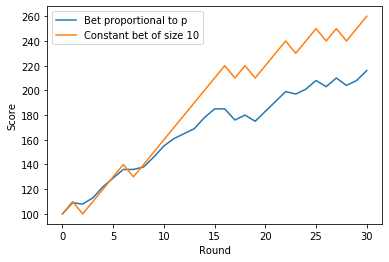

In [5]:
# Plot an example
score_histories, _, _ = run_bets(30, [policy_linear, policy_const], max_p=1.0)

plt.plot(score_histories[0], label='Bet proportional to p')
plt.plot(score_histories[1], label='Constant bet of size 10')
plt.legend()
plt.xlabel('Round')
plt.ylabel('Score')

In [6]:
def run_ensemble(num_sims, num_rounds, policies, max_p=1.0, rng=rng):
    """
    Runs an ensemble of sims and returns the final scores.
    """
    
    final_scores = [[] for _ in policies]
    
    for _ in range(num_sims):
        score_histories, _, _ = run_bets(num_rounds, policies, max_p=max_p, rng=rng)
        for i, _ in enumerate(policies):
            final_scores[i].append(score_histories[i][-1])
    
    return [np.array(s) for s in final_scores]

# What is the distribution of final scores?

In [7]:
final_scores = run_ensemble(5000, 30, [policy_linear, policy_const], max_p=1.0)

Text(0.5, 0, 'Final score')

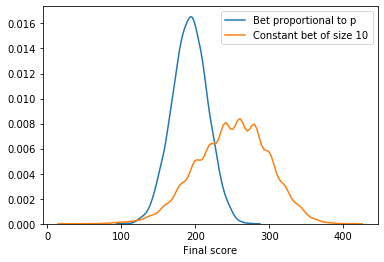

In [8]:
# Visualize the distributions by estimating a smoothing of the probability mass function.
# Note that you definitely want to do some smoothing and not just plot a histogram, or you'll have
# big spikes at the multiples of 10 for the policy of just betting 10.
seaborn.kdeplot(final_scores[0], label='Bet proportional to p')
seaborn.kdeplot(final_scores[1], label='Constant bet of size 10')
plt.xlabel('Final score')

In [9]:
# The performance of the policies is not independent, since we're running counterfactuals.
# We can actually ask the question 'What is the probability that policy 2 would have beaten
# policy 1 for any fixed game?'

p_const_beats_linear = (final_scores[1] > final_scores[0]).mean()
print(f'The "always bet 10" policy wins with probability {p_const_beats_linear}')

The "always bet 10" policy wins with probability 0.9568


# How does this vary with differing `p_max`?

I've assumed up to now that our probability of answering a question correctly is uniformly distributed between 0 and 1. But what if our knowledge is poor, and we know it, and so our maximum probability of being correct is lower?

Specifically, does the "always bet 10" policy become less competitive?

In [10]:
max_p_vals = []
win_prob_vals = []


for max_p in tqdm(np.arange(0.55, 1.001, 0.05)):
    final_scores = run_ensemble(5000, 30, [policy_linear, policy_const], max_p=max_p)
    p_const_beats_linear = (final_scores[1] > final_scores[0]).mean()
    
    max_p_vals.append(max_p)
    win_prob_vals.append(p_const_beats_linear)

100%|██████████| 10/10 [01:21<00:00,  8.09s/it]


(0.5, 1.0)

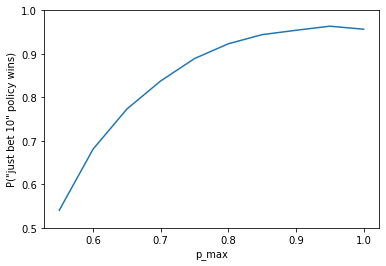

In [11]:
plt.plot(max_p_vals, win_prob_vals)
plt.xlabel('p_max')
plt.ylabel('P("just bet 10" policy wins)')
plt.ylim(bottom=0.5, top=1.0)

# 'Restricted' Kelly Betting

I only realized that the linear solution might not be the best policy because of Kelly betting. The Kelly bet would usually involve placing a much higher stake than our maximum of 10, but not always. We're also not able to bet fractional points. Nevertheless, we can write a third policy that is closer to Kelly betting than either of the policies considered so far.

In [12]:
def policy_kelly(p, s):
    ideal_kelly_bet = (2*p - 1)*s
    rounded_kelly_bet = np.round(ideal_kelly_bet)
    restricted_kelly_bet = np.clip(rounded_kelly_bet, 0, 10)
    return restricted_kelly_bet

In [13]:
max_p_vals = []
p_const_beats_linear_vals = []
p_kelly_beats_linear_vals = []
p_kelly_beats_const_vals = []
p_kelly_beats_or_equals_const_vals = []

for max_p in tqdm(np.arange(0.55, 1.001, 0.025)):
    final_scores = run_ensemble(5000, 30, [policy_linear, policy_const, policy_kelly], max_p=max_p)
    p_const_beats_linear_vals.append((final_scores[1] > final_scores[0]).mean())
    p_kelly_beats_linear_vals.append((final_scores[2] > final_scores[0]).mean())
    p_kelly_beats_const_vals.append((final_scores[2] > final_scores[1]).mean())
    p_kelly_beats_or_equals_const_vals.append((final_scores[2] >= final_scores[1]).mean())
    
    max_p_vals.append(max_p)

100%|██████████| 19/19 [03:45<00:00, 11.97s/it]


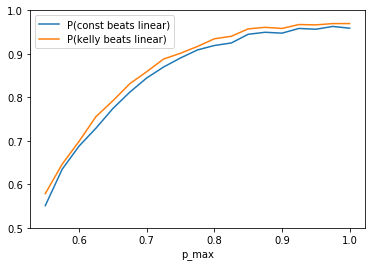

In [14]:
plt.plot(max_p_vals, p_const_beats_linear_vals, label='P(const beats linear)')
plt.plot(max_p_vals, p_kelly_beats_linear_vals, label='P(kelly beats linear)')
plt.xlabel('p_max')
#plt.ylabel('P("just bet 10" policy wins)')
plt.ylim(bottom=0.5, top=1.0)
plt.legend()

The above shows that restricted Kelly betting has a small advantage over the "just bet 10" policy. Presumably the advantage is small because their is only a small probability of a drawdown that is large enough that the policies differ.

Note that it does _not_ appear to be true that Kelly betting reliably beats the "just bet 10" policy:

Text(0, 0.5, 'P(Kelly beats const)')

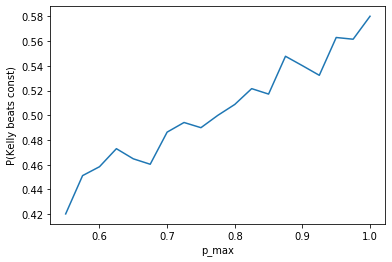

In [15]:
plt.plot(max_p_vals, p_kelly_beats_or_equals_const_vals)
plt.xlabel('p_max')
plt.ylabel('P(Kelly beats const)')

I'm not 100% sure why this is, but I have a hypothesis:

1. These two strategies only differ when the stake falls below a certain amount (certainly below 100).
The outcome of the next bet is more likely to be a win than a loss (p is never below 0.5), in which case the "just bet 10" policy will get a larger gain than Kelly betting.
2. Why does this argument not invalidate Kelly betting in general? I think it's because in the 'usual' case we assume that the wealth is fully stake-able, and larger losses invalidate our ability to place a large constant bet. This is very unlikely here since we're unlikely to fall below 10 points.